In [ ]:
import marimo as mo

# --- Notebook Setup ---
mo.md(
    f"""
    # 📸 Camera Calibration Playground
    ### Inspired by: [Ara Intelligence - Camera Calibration](https://araintelligence.com/blogs/computer-vision/geometric-vision/camera_calibration)

    This notebook serves as an interactive Python mirror of the Ara Intelligence blog post. We will walk through determining a camera's **Intrinsic** and **Extrinsic** parameters to correct lens distortion and understand 3D-to-2D projections.
    """
)

# --- Imports ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import requests
import os
from PIL import Image
import io

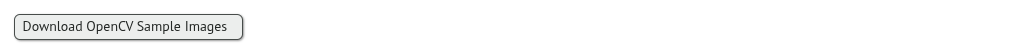

In [ ]:
# --- Theory Section ---
mo.md(
    r"""
    ## 1. The Pinhole Camera Model
    The goal is to find the **Camera Matrix ($K$)** and **Distortion Coefficients**.

    - **Intrinsic Parameters ($K$):** Focal length ($f_x, f_y$), Principal point ($c_x, c_y$), and Skew ($s$).
    - **Extrinsic Parameters ($[R|t]$):** The rotation and translation of the camera in the 3D world.
    - **Projection Equation:** $q_c = K * [R|t] * q_w$

    $$K = \begin{bmatrix} f_x & s & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$$
    """
)

# --- Interactive Configuration ---
mo.md("## 2. Setup Your Calibration Target")
board_width = mo.ui.number(start=1, stop=20, step=1, value=9, label="Chessboard Corners (Width)")
board_height = mo.ui.number(start=1, stop=20, step=1, value=6, label="Chessboard Corners (Height)")
square_size = mo.ui.number(start=0.1, stop=100.0, step=0.1, value=25.0, label="Square Size (mm)")

mo.hstack([board_width, board_height, square_size])

# --- Sample Data Downloader ---
mo.md("### Get Sample Images")
load_samples = mo.ui.button(label="Download OpenCV Sample Images")
load_samples

In [ ]:
if load_samples.value:
    os.makedirs("calib_samples", exist_ok=True)
    # OpenCV samples names: left01.jpg, left02.jpg ... left14.jpg
    for i in range(1, 15):
        num = f"{i:02d}"
        url = f"https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left{num}.jpg"
        r = requests.get(url)
        with open(f"calib_samples/left{num}.jpg", "wb") as f:
            f.write(r.content)
    mo.md("✅ Samples downloaded to `./calib_samples/`")
else:
    mo.md("Click the button above to use standard OpenCV calibration samples.")

# --- The Calibration Logic ---
def run_calibration(image_paths, pattern_size, sq_size):
    # Prepare object points (0,0,0), (1,0,0), (2,0,0) ...
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
    objp *= sq_size

    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    processed_images = []

    for fname in image_paths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 1. Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

        if ret:
            objpoints.append(objp)

            # Refine corners (Sub-pixel accuracy)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw for visualization
            cv2.drawChessboardCorners(img, pattern_size, corners2, ret)
            processed_images.append(img)

    # 2. Calibrate
    if not objpoints:
        return None, None, None, None, None

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None
    )

    return mtx, dist, rvecs, tvecs, processed_images

In [ ]:
# --- Execution & Results ---
images = glob.glob('calib_samples/*.jpg')
if images:
    mtx, dist, rvecs, tvecs, viz_images = run_calibration(
        images, (board_width.value, board_height.value), square_size.value
    )

    if mtx is not None:
        mo.md("## 3. Calibration Results")

        col1, col2 = mo.columns([1, 1])
        with col1:
            mo.md(f"**Camera Matrix (K):**\n```python\n{mtx}\n```")
        with col2:
            mo.md(f"**Distortion Coefficients:**\n`k1, k2, p1, p2, k3`\n```python\n{dist.ravel()}\n```")

        # --- Undistortion Playground ---
        mo.md("## 4. Undistortion Playground")
        sample_idx = mo.ui.slider(start=0, stop=len(images)-1, value=0, label="Select Image")

        original = cv2.imread(images[sample_idx.value])
        # Method: cv2.undistort
        undistorted = cv2.undistort(original, mtx, dist, None, mtx)

        # Compare
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        ax[0].set_title("Original (Distorted)")
        ax[1].imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
        ax[1].set_title("Undistorted")
        plt.close()

        mo.hstack([sample_idx])
        mo.as_html(fig)

        mo.md(
            """
            ### Tips for Better Results:
            - **Coverage:** Ensure the chessboard covers the edges of the frame (where distortion is strongest).
            - **Angles:** Tilt the pattern (X, Y axis and Skew) as mentioned in the blog.
            - **Count:** Use at least 10-15 high-quality images.
            """
        )
    else:
        mo.md("❌ No corners detected. Check your pattern size settings.")
else:
    mo.md("⚠️ No images found. Please download samples or provide a path.")

# --- Bonus: The Extrinsic View (Pose Estimation) ---
if 'mtx' in locals() and mtx is not None:
    mo.md(
        r"""
        ## 5. Extrinsic Parameters: Camera Pose
        Using `cv2.solvePnP`, we can find the rotation ($R$) and translation ($t$) for each image. This is the core of Augmented Reality!
        """
    )

    # Calculate Mean Reprojection Error
    mean_error = 0
    # (Simplified error calculation)
    # In a full app, you'd project 3D points back and compare to detected 2D points.
    mo.md(f"**Reprojection Error:** Calculations can be added here to verify accuracy.")